In [32]:
# libraries
import pandas as pd
from matplotlib import pyplot
from sklearn import metrics 
from sklearn.model_selection import KFold
import numpy as np 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
#paths to the file containing the samples with the processed features
feature_of_counts = "../processed_data/feature_vectors_counts.csv"

In [8]:
# Importing the dataset, and performing an undersampling of the benignware
dataset = pd.read_csv(feature_of_counts, index_col=0)

malware= dataset.loc[dataset["malware"] == True]
benign = dataset.loc[dataset["malware"] == False]
benign_undersample = benign.sample(n=len(malware), replace= False, random_state=42)

dataset= pd.concat([malware, benign_undersample])
X = dataset.iloc[:,1:9].values
y = dataset.iloc[:, 9].values

In [4]:
# Splitting (randomly) the dataset into the Training set and the (unseen) Test set
# Note this is only for the first task of the coursework. You'll need a different approach for the other tasks, as they also need a validation stage in addition to the test with unseen data.
# Also note the split is training 80% and test 20%) 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), random_state=42, test_size = 0.2)


In [5]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


## Random Forest Classifier

Based on [this](https://blog.dataiku.com/narrowing-the-search-which-hyperparameters-really-matter) article, min_samples_leaf and max_features are the most important hyperparameters for the Random Forest Classifier. At least for his project.

In [6]:
# Fitting the model to the Training set
from sklearn.ensemble import RandomForestClassifier

In [45]:
# creating a RF classifier and performing a crossvalidation for it
X_train_RF , y_train_RF = np.array(X_train), np.array(y_train)
kf = KFold(n_splits=3,shuffle=True)

avarage_auc_RF_max = 0 
min_samples_leaf_best = 0 
max_features_best = 0

for min_samples_leaf in [1, 20, 40]:
    for max_features in [None, "sqrt", 0.2]:
        avarage_auc = 0
        for train, test in kf.split(X_train_RF):
            training_X , training_y = X_train_RF[train], y_train_RF[train]
            test_X, train_y = X_train_RF[test], y_train_RF[test]

            clf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
            clf.fit(training_X, training_y)
            scores_clf = clf.predict_proba(test_X)[:,1]

            AUC_rfc = metrics.roc_auc_score(train_y, scores_clf)
            avarage_auc = avarage_auc + AUC_rfc
            
        avarage_auc = avarage_auc/kf.get_n_splits()
        if avarage_auc > avarage_auc_RF_max:
            avarage_auc_RF_max = avarage_auc
            min_samples_leaf_best = min_samples_leaf
            max_features_best = max_features
            print(f"min_samples_leaf: {min_samples_leaf_best}, max_features: {max_features_best} gives the avarage AUC: {avarage_auc_RF_max}")


min_samples_leaf: 1, max_features: None gives the avarage AUC: 0.9754551519332463
min_samples_leaf: 1, max_features: sqrt gives the avarage AUC: 0.9787910305058244


ACCURACY OF THE MODEL for Random forest: 0.9348021582733813
PRECISION OF MODEL for Random forest: 0.9314079422382672
RECALL OF MODEL for Random forest: 0.9373297002724795
F1-SCORE OF MODEL for Random forest: 0.9343594386600271


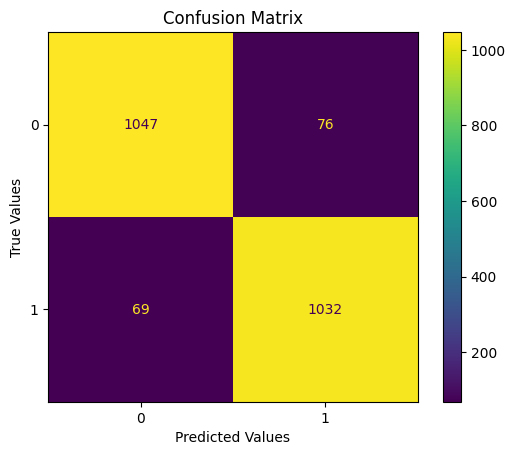

In [35]:
clf_best = RandomForestClassifier(min_samples_leaf=min_samples_leaf_best, max_features=max_features_best, random_state=42)
clf_best.fit(X_train, y_train)
scores_clf_best = clf_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_clf_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_clf_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_clf_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_clf_best))

ConfusionMatrixDisplay.from_estimator(clf_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()



## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

In [43]:
X_train_log , y_train_log = np.array(X_train), np.array(y_train)
kf = KFold(n_splits=3,shuffle=True)

avarage_auc_log_min = 0 
algorithm_best = ""
toleration_best = 0
regulation_best = 0 
iter_best = 0 

for algorithm in ['lbfgs', 'newton-cg']:
  for toleration in (1e-4, 1e-3,1e-2):
    for regulation in (1e-1, 1e1):
      for iter in (100, 1000):
        avarage_auc = 0 
        for train, test in kf.split(X_train_RF):
          training_X , training_y = X_train_log[train], y_train_log[train]
          test_X, train_y = X_train_log[test], y_train_log[test]
          
          log = LogisticRegression(solver = algorithm, tol = toleration, C= regulation, random_state = 42,  max_iter=iter)
          log.fit(training_X, training_y)
          scores_log = log.predict_proba(test_X)[:,1]

          AUC_log = metrics.roc_auc_score(train_y, scores_log)
          avarage_auc += AUC_log
          
        avarage_auc = avarage_auc/kf.get_n_splits()
        if avarage_auc > avarage_auc_log_min:
            avarage_auc_log_min = avarage_auc 
            algorithm_best = algorithm
            toleration_best = toleration
            regulation_best = regulation
            iter_best = iter
            print(f"Solver {algorithm_best!s}, toleration {toleration_best:g}, regulation {regulation_best:g}, itteration {iter_best:g} gives the avarage AUC of {avarage_auc_log_min:g}")
 

Solver lbfgs, toleration 0.0001, regulation 0.1, itteration 100 gives the avarage AUC of 0.894631
Solver lbfgs, toleration 0.0001, regulation 10, itteration 100 gives the avarage AUC of 0.896334
Solver newton-cg, toleration 0.0001, regulation 10, itteration 1000 gives the avarage AUC of 0.896425


ACCURACY OF THE MODEL for Random forest: 0.8232913669064749
PRECISION OF MODEL for Random forest: 0.8568548387096774
RECALL OF MODEL for Random forest: 0.7720254314259763
F1-SCORE OF MODEL for Random forest: 0.8122312470138557


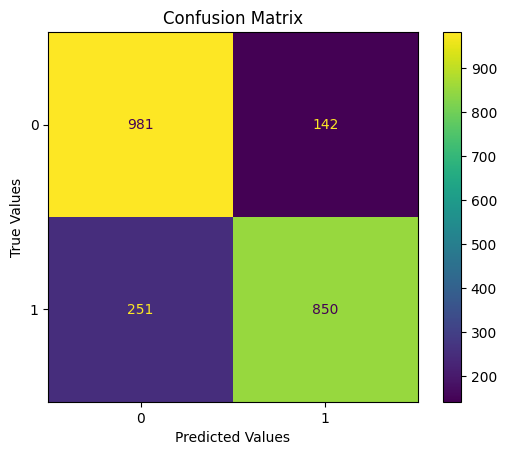

In [44]:
log_best = LogisticRegression(solver = algorithm_best, tol = toleration_best, C= regulation_best, random_state = 42,  max_iter=iter_best)
log_best.fit(X_train, y_train)
scores_log_best = log_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_log_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_log_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_log_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_log_best))

ConfusionMatrixDisplay.from_estimator(log_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

## Gradient Boosting Classifier

[This](https://aiml.com/what-are-the-key-hyper-parameters-for-a-gbm-model/) article defines *learning_rate* and *n_estimators* as the two most important hyperparameters

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
X_train_GBC , y_train_GBC = np.array(X_train), np.array(y_train)
kf = KFold(n_splits=3,shuffle=True)

avarage_auc_gbc_min = 0 
learning_rate_best = 0
n_estimators_best = 0

for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [2, 8, 16]:
        avarage_auc = 0 
        for train, test in kf.split(X_train_RF):
            training_X , training_y = X_train_GBC[train], y_train_GBC[train]
            test_X, train_y = X_train_GBC[test], y_train_GBC[test]

            gb= GradientBoostingClassifier(learning_rate=learning_rate,n_estimators=n_estimators ,random_state=42)
            gb.fit(training_X, training_y)
            scores_gb = gb.predict_proba(test_X)[:,1]

            AUC_gb = metrics.roc_auc_score(train_y, scores_gb)
            avarage_auc += AUC_gb
            
        avarage_auc = avarage_auc/kf.get_n_splits()
        if avarage_auc > avarage_auc_gbc_min:
            avarage_auc_gbc_min = avarage_auc
            learning_rate_best = learning_rate
            n_estimators_best = n_estimators
            print(f"learning_rate: {learning_rate_best}, n_estimators: {n_estimators_best} gives the avarage AUC: {avarage_auc_gbc_min}")

learning_rate: 0.05, n_estimators: 2 gives the avarage AUC: 0.8768861255919013
learning_rate: 0.05, n_estimators: 8 gives the avarage AUC: 0.8914689490059721
learning_rate: 0.05, n_estimators: 16 gives the avarage AUC: 0.9002455675211731
learning_rate: 0.1, n_estimators: 16 gives the avarage AUC: 0.915392128225298
learning_rate: 0.2, n_estimators: 16 gives the avarage AUC: 0.9300365158313292


ACCURACY OF THE MODEL for Random forest: 0.8588129496402878
PRECISION OF MODEL for Random forest: 0.8640148011100832
RECALL OF MODEL for Random forest: 0.8483197093551317
F1-SCORE OF MODEL for Random forest: 0.8560953253895509


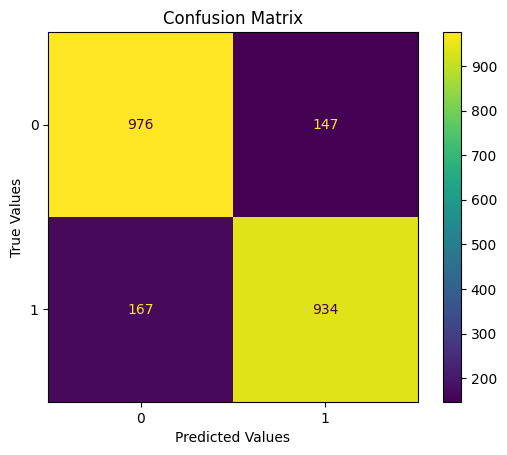

In [39]:
gb_best = GradientBoostingClassifier(learning_rate=learning_rate_best,n_estimators=n_estimators_best ,random_state=42)
gb_best.fit(X_train, y_train)
scores_gb_best = gb_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_gb_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_gb_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_gb_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_gb_best))

ConfusionMatrixDisplay.from_estimator(gb_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()

## Ada Boost Classifier

[This](https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff) article defines *n_estimators* as the most important hyperparameter, with *learning_rate* and *base_estimator* as two other important ones. We will tweak n_estimators and learning_rate.

In [23]:
from sklearn.ensemble import AdaBoostClassifier

In [41]:
X_train_abc , y_train_abc = np.array(X_train), np.array(y_train)
kf = KFold(n_splits=3,shuffle=True)

avarage_auc_abc_min = 0 
learning_rate_best = 0
n_estimators_best = 0 

for learning_rate in [0.05, 0.1, 0.2]:
    for n_estimators in [2, 8, 16]:
        avarage_auc = 0 
        for train, test in kf.split(X_train_RF):
            training_X , training_y = X_train_abc[train], y_train_abc[train]
            test_X, train_y = X_train_abc[test], y_train_abc[test]

            abc= AdaBoostClassifier(learning_rate=learning_rate, n_estimators=n_estimators,random_state=42)
            abc.fit(training_X, training_y)
            scores_abc = abc.predict_proba(test_X)[:,1]

            AUC_abc = metrics.roc_auc_score(train_y, scores_abc)
            avarage_auc = AUC_abc

        avarage_auc = avarage_auc/kf.get_n_splits()
        if avarage_auc > avarage_auc_abc_min:
            avarage_auc_abc_min = avarage_auc
            learning_rate_best = learning_rate
            n_estimators_best = n_estimators
            print(f"learning_rate: {learning_rate_best}, n_estimators: {n_estimators_best} gives the avarage AUC: {avarage_auc_abc_min}")
            

learning_rate: 0.05, n_estimators: 2 gives the avarage AUC: 0.25161895776548765
learning_rate: 0.05, n_estimators: 8 gives the avarage AUC: 0.27260826985755154
learning_rate: 0.05, n_estimators: 16 gives the avarage AUC: 0.28020532970713735
learning_rate: 0.1, n_estimators: 16 gives the avarage AUC: 0.28521173128656624
learning_rate: 0.2, n_estimators: 16 gives the avarage AUC: 0.29328137150582806


ACCURACY OF THE MODEL for Random forest: 0.8111510791366906
PRECISION OF MODEL for Random forest: 0.8120989917506874
RECALL OF MODEL for Random forest: 0.8047229791099001
F1-SCORE OF MODEL for Random forest: 0.8083941605839416


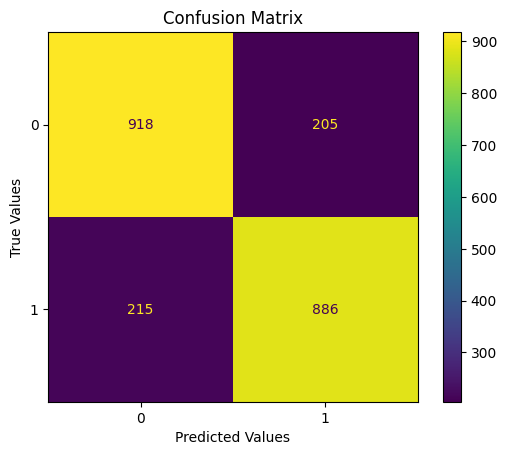

In [42]:
abc_best = AdaBoostClassifier(learning_rate=learning_rate_best, n_estimators=n_estimators_best,random_state=42)
abc_best.fit(X_train, y_train)
scores_abc_best = abc_best.predict(X_test)

print("ACCURACY OF THE MODEL for Random forest:", metrics.accuracy_score(y_test, scores_abc_best))
print("PRECISION OF MODEL for Random forest:", metrics.precision_score(y_test, scores_abc_best))
print("RECALL OF MODEL for Random forest:", metrics.recall_score(y_test, scores_abc_best))
print("F1-SCORE OF MODEL for Random forest:", metrics.f1_score(y_test, scores_abc_best))

ConfusionMatrixDisplay.from_estimator(abc_best, X_test, y_test)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()